In [2]:
## Imports libs
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
print(tf.__version__) 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import itertools
import random
import os

2.2.0


In [7]:
data =  pd.read_csv('./dataset/bitcoin/bitcoin_10min_dataset.csv', header=0)

In [28]:
data.head()

,Date,Open,High,Low,Close,SMAVG_50d,SMAVG_100d,SMAVG_200d
37782,2022-04-01 00:10:00,45680.63,45714.11,45638.63,45665.02,45895.07,46512.44,46840.99
37781,2022-04-01 00:20:00,45665.07,45705.22,45633.79,45696.46,45876.87,46497.72,46834.89
37780,2022-04-01 00:30:00,45696.46,45731.87,45658.29,45667.18,45858.10,46482.98,46827.55
37779,2022-04-01 00:40:00,45669.05,45688.13,45231.34,45411.71,45835.46,46465.93,46818.93
37778,2022-04-01 00:50:00,45411.71,45568.35,45336.02,45528.45,45814.66,46449.71,46810.66


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26207 entries, 37782 to 11576
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        26207 non-null  datetime64[ns]
 1   Open        26207 non-null  float64       
 2   High        26207 non-null  float64       
 3   Low         26207 non-null  float64       
 4   Close       26207 non-null  float64       
 5   SMAVG_50d   26207 non-null  float64       
 6   SMAVG_100d  26207 non-null  float64       
 7   SMAVG_200d  26207 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.8 MB


In [15]:
data['Date']=pd.to_datetime(data['Date'])

In [20]:
data=data.sort_values(by="Date", ascending=True)

In [25]:
data=data[(data['Date'] >= '2022-04-01') & (data['Date'] <= '2022-09-30')]

In [30]:
data_prices = data.drop(['Date'], axis=1)

In [31]:
data_prices = data_prices.drop(['Open', 'Low', 'High','SMAVG_100d'], axis=1)


In [32]:
data_prices

,Close,SMAVG_50d,SMAVG_200d
37782,45665.02,45895.07,46840.99
37781,45696.46,45876.87,46834.89
37780,45667.18,45858.10,46827.55
37779,45411.71,45835.46,46818.93
37778,45528.45,45814.66,46810.66
...,...,...,...
11580,19521.14,19343.86,19411.07
11579,19462.57,19354.10,19413.19
11578,19452.66,19365.23,19414.81
11577,19427.41,19374.05,19416.21


### Feature Scaling

In [81]:
sc = MinMaxScaler(feature_range=(0, 1))
data_prices_scaled = sc.fit_transform(data_prices)


In [85]:

sc_pred = MinMaxScaler(feature_range=(0, 1))
data_close_price = pd.DataFrame(data_prices['Close'])
data_pred_scaled = sc_pred.fit_transform(data_close_price)

In [80]:
data_prices['Close']

37782    45665.02
37781    45696.46
37780    45667.18
37779    45411.71
37778    45528.45
           ...   
11580    19521.14
11579    19462.57
11578    19452.66
11577    19427.41
11576    19460.94
Name: Close, Length: 26207, dtype: float64

In [35]:
data_prices_scaled.shape

(26207, 3)

In [37]:
# Creating a data structure (it does not work when you have only one feature)
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []
    
    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])
    
    split_training_test_starting_point = int(round(train_test_split_percentage*len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-validation_split_percentage)))
    
    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]
    
    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val =  x_data[split_train_validation_starting_point:split_training_test_starting_point]                                             
    
    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]
    
    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [38]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_data(data_prices_scaled, n_future=1, n_past=6, train_test_split_percentage=0.8,
                                               validation_split_percentage = 0)

In [47]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(20961, 6, 3)
(5240, 6, 3)
(20961, 1)
(5240, 1)


### Train LSTM Model


In [52]:
print(X_train.shape[1])
print(X_train.shape[2])

6
3


In [48]:
# ------------------LSTM-----------------------
regressor = Sequential()
regressor.add(LSTM(units=16, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 16)             1280      
_________________________________________________________________
dropout (Dropout)            (None, 6, 16)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 3,409
Trainable params: 3,409
Non-trainable params: 0
_________________________________________________________________


In [49]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=64, callbacks=[es])

Epoch 1/40
230/230 [==============================] - 3s 14ms/step - loss: 0.0281 - root_mean_squared_error: 0.1675 - val_loss: 2.5117e-04 - val_root_mean_squared_error: 0.0158
Epoch 2/40
230/230 [==============================] - 4s 16ms/step - loss: 0.0062 - root_mean_squared_error: 0.0784 - val_loss: 1.7719e-04 - val_root_mean_squared_error: 0.0133
Epoch 3/40
230/230 [==============================] - 3s 14ms/step - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 9.4829e-05 - val_root_mean_squared_error: 0.0097
Epoch 4/40
230/230 [==============================] - 3s 15ms/step - loss: 0.0044 - root_mean_squared_error: 0.0662 - val_loss: 1.1538e-04 - val_root_mean_squared_error: 0.0107
Epoch 5/40
230/230 [==============================] - 3s 14ms/step - loss: 0.0037 - root_mean_squared_error: 0.0611 - val_loss: 1.2065e-04 - val_root_mean_squared_error: 0.0110
Epoch 6/40
230/230 [==============================] - 3s 13ms/step - loss: 0.0034 - root_mean_squared_error: 0.0582

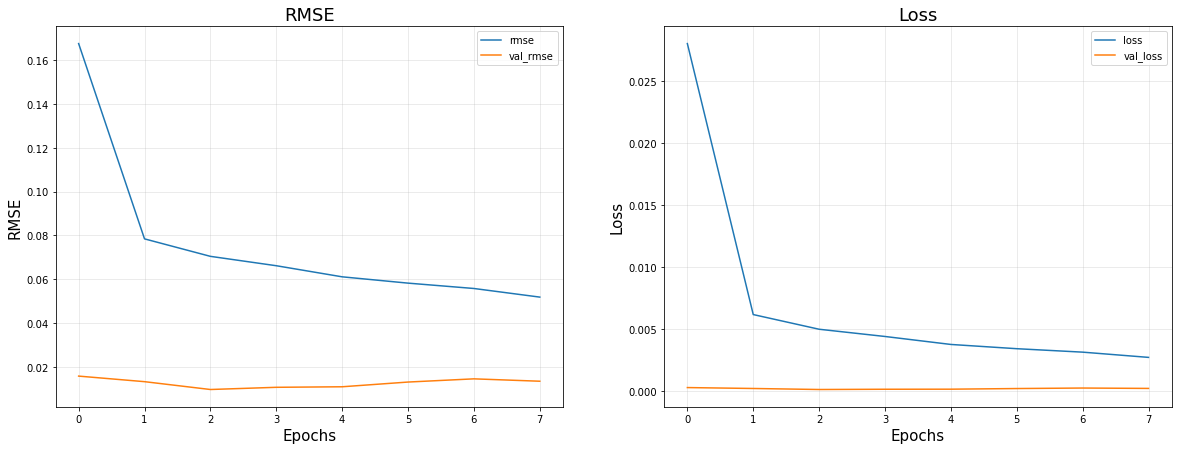

In [50]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [51]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

164/164 [==============================] - 0s 3ms/step - loss: 1.0381e-04 - root_mean_squared_error: 0.0102
test loss, test acc: [0.0001 0.0102]


### Hyperparameter Tunning

In [54]:
def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

In [55]:
config = [[False], [False], [False], [16, 32], [8, 16, 32], [0.2]]  

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)  # change x_train shape

[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 16, 0.2), (False, False, False, 32, 32, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 00001: val_loss improved from inf to 0.00007, saving model to best_model.h5

Epoch 00002: val_loss did not improve from 0.00007

Epoch 00003: val_loss did not improve from 0.00007

Epoch 00004: val_loss improved from 0.00007 to 0.00004, saving model to best_model.h5

Epoch 00005: val_loss did not improve from 0.00004

Epoch 00006: val_loss improved from 0.00004 to 0.00003, saving model to best_model.h5

Epoch 00007: val_loss improved from 0.00003 to 0.00002, saving model to best_model.h5

Epoch 00008: val_loss did not improve from 0.00002

Epoch 00009: val_loss did not improve from 0.00002

Epoch 00010: val_loss did not improve from 0.00002

Epoch 00011: val_loss did not improve 

In [56]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
5,False,False,False,32,32,0.2,"[0.00011023916158592328, 0.010499483905732632]","[1.5906898624962196e-05, 0.00398834515362978]"
0,False,False,False,16,8,0.2,"[5.068053724244237e-05, 0.007119026500731707]","[2.5393163014086895e-05, 0.0050391629338264465]"
3,False,False,False,32,8,0.2,"[4.7083802201086655e-05, 0.006861764006316662]","[5.882513869437389e-05, 0.007669754792004824]"
1,False,False,False,16,16,0.2,"[0.00013779681466985494, 0.011738688684999943]","[8.050991164054722e-05, 0.008972731418907642]"
2,False,False,False,16,32,0.2,"[0.00027068296913057566, 0.016452446579933167]","[0.00018709457071963698, 0.013678251765668392]"
4,False,False,False,32,16,0.2,"[0.00012150517432019114, 0.011022938415408134]","[0.000247101386776194, 0.0157194584608078]"


In [57]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 32
 n_batch_size = 32
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.0102

Results After Tunning:
 Test Set RMSE: 0.004

61.0% Improvement


In [58]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

In [59]:
regressor = Sequential()
regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

file_path = 'best_model.h5'

mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)


Epoch 00001: val_loss improved from inf to 0.00015, saving model to best_model.h5

Epoch 00002: val_loss improved from 0.00015 to 0.00011, saving model to best_model.h5

Epoch 00003: val_loss improved from 0.00011 to 0.00009, saving model to best_model.h5

Epoch 00004: val_loss improved from 0.00009 to 0.00006, saving model to best_model.h5

Epoch 00005: val_loss improved from 0.00006 to 0.00003, saving model to best_model.h5

Epoch 00006: val_loss improved from 0.00003 to 0.00002, saving model to best_model.h5

Epoch 00007: val_loss improved from 0.00002 to 0.00002, saving model to best_model.h5

Epoch 00008: val_loss did not improve from 0.00002

Epoch 00009: val_loss did not improve from 0.00002

Epoch 00010: val_loss did not improve from 0.00002

Epoch 00011: val_loss did not improve from 0.00002

Epoch 00012: val_loss did not improve from 0.00002
Epoch 00012: early stopping


In [62]:
results=regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

164/164 [==============================] - 1s 4ms/step - loss: 9.5658e-05A: 0s - loss: 8.7923e
test loss, test acc: 0.0001


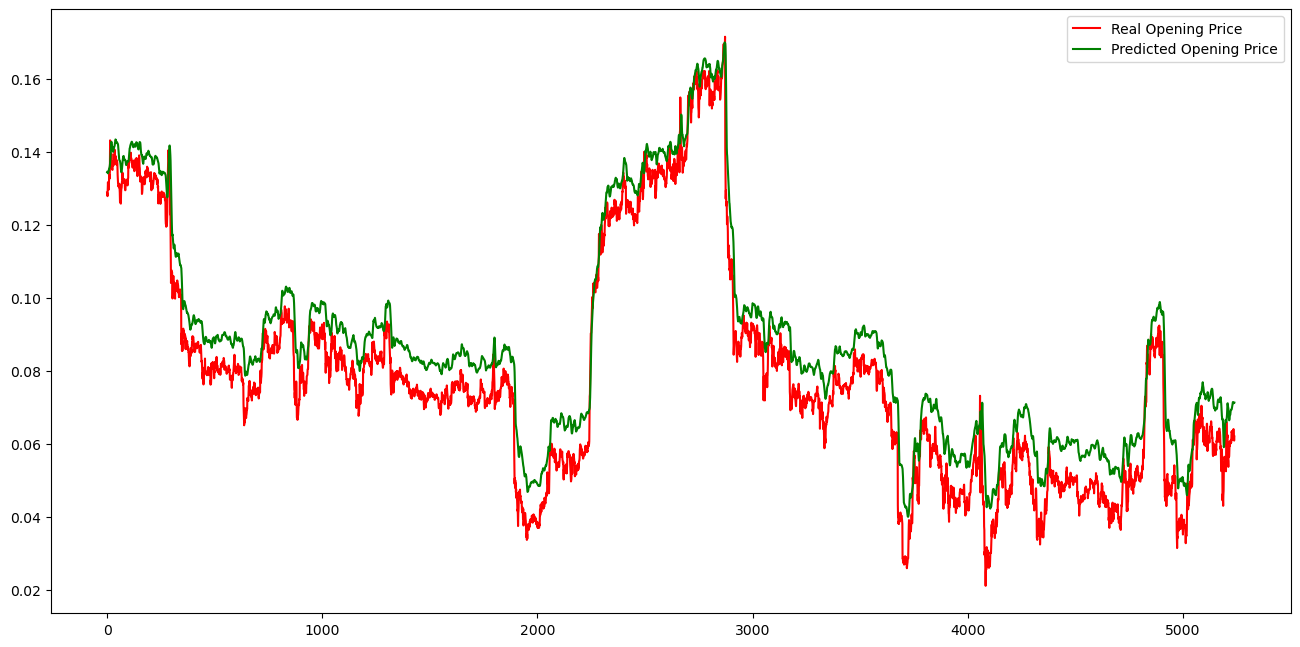

In [61]:
y_pred = regressor.predict(X_test)

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real Close Price')
plt.plot(y_pred, color='green', label = 'Predicted Close Price')
plt.legend(loc='best')

In [91]:
predicted_btc_price_test_data = sc_pred.inverse_transform(y_pred)
test_actual = sc_pred.inverse_transform(y_test.reshape(-1, 1))

In [94]:
predicted_btc_price_test_data

array([[21613.738],
       [21618.385],
       [21612.777],
       ...,
       [19733.885],
       [19737.941],
       [19737.35 ]], dtype=float32)

In [95]:
test_actual

array([[21447.93],
       [21440.1 ],
       [21418.53],
       ...,
       [19452.66],
       [19427.41],
       [19460.94]])

In [ ]:
display_start_date = "2022-04-01" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_prices['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_prices['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])